In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [2]:
train = pd.read_csv("Data/train_processed.csv")
test = pd.read_csv("Data/test_processed.csv")
sub_sample = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

print (train.shape, test.shape, sub_sample.shape)

(7613, 22) (3263, 21) (3263, 2)


## Random Forest

Como parte del preprocesamiento se escalan los datos aplicando normalizacion y como modelo Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier


features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

rf_model = RandomForestClassifier(max_depth=200, n_estimators=400, min_samples_split=20, min_samples_leaf=1,
                           max_features=10)
rf_model.fit(X_train, y_train)

y_test = rf_model.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_random_forest.csv',index=False)

In [4]:
rf_model.feature_importances_
np.amax(rf_model.feature_importances_)

0.49771904870370953

In [5]:
X_train.columns

Index(['Unnamed: 0', 'text_len', 'word_count', 'stop_word_count',
       'punctuation_count', 'hashtag_count', 'mention_count', 'link_count',
       'caps_count', 'caps_ratio', 'keyword_target', 'location_clean_target'],
      dtype='object')

In [6]:
data = [X_train.columns, rf_model.feature_importances_]
print(data)

[Index(['Unnamed: 0', 'text_len', 'word_count', 'stop_word_count',
       'punctuation_count', 'hashtag_count', 'mention_count', 'link_count',
       'caps_count', 'caps_ratio', 'keyword_target', 'location_clean_target'],
      dtype='object'), array([0.08830226, 0.09154434, 0.0414505 , 0.05821433, 0.04462246,
       0.01031536, 0.01175869, 0.00582035, 0.02968792, 0.08543973,
       0.49771905, 0.03512501])]


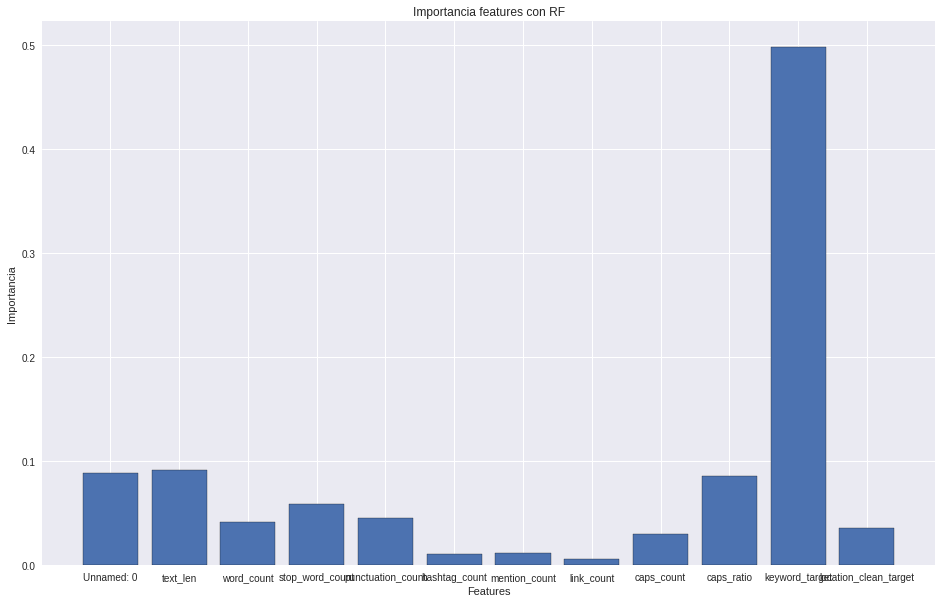

In [11]:
# Gini importance
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia features con RF')
plt.show()

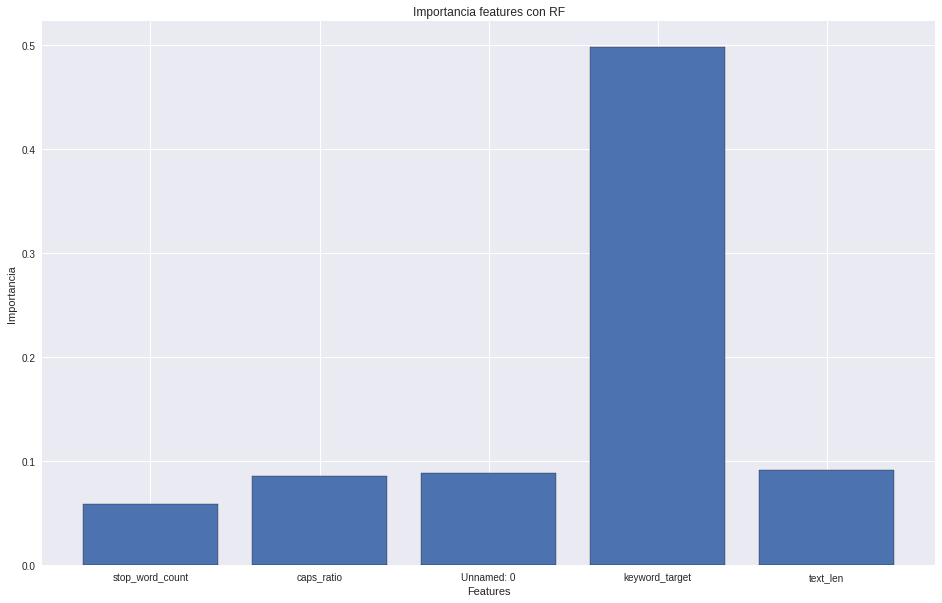

In [13]:
top = 5
# Obtengo los "top" índices de las features más importantes
indices = np.argpartition(rf_model.feature_importances_, -top)[-top:]
importances = rf_model.feature_importances_
columns = X_train.columns
top_importances = [importances[index] for index in indices]
top_columns = [columns[index] for index in indices]

plt.bar(top_columns, top_importances)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia features con RF')
plt.show()

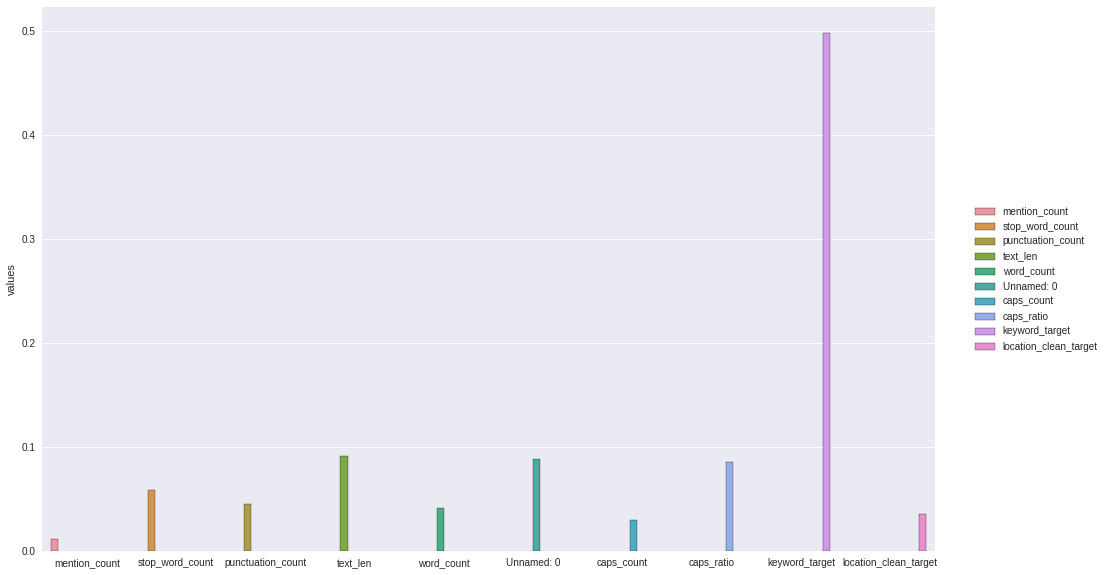

In [9]:

# plt styling parameters
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams["patch.force_edgecolor"] = True

df = pd.DataFrame({
    'names': top_columns,
    'values': top_importances
})

# create a color palette the length of the dataframe
colors = sns.color_palette('husl', n_colors=len(df))
# plot
p = sns.barplot(x=top_columns, y='values', data=df, hue='names')

# place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)

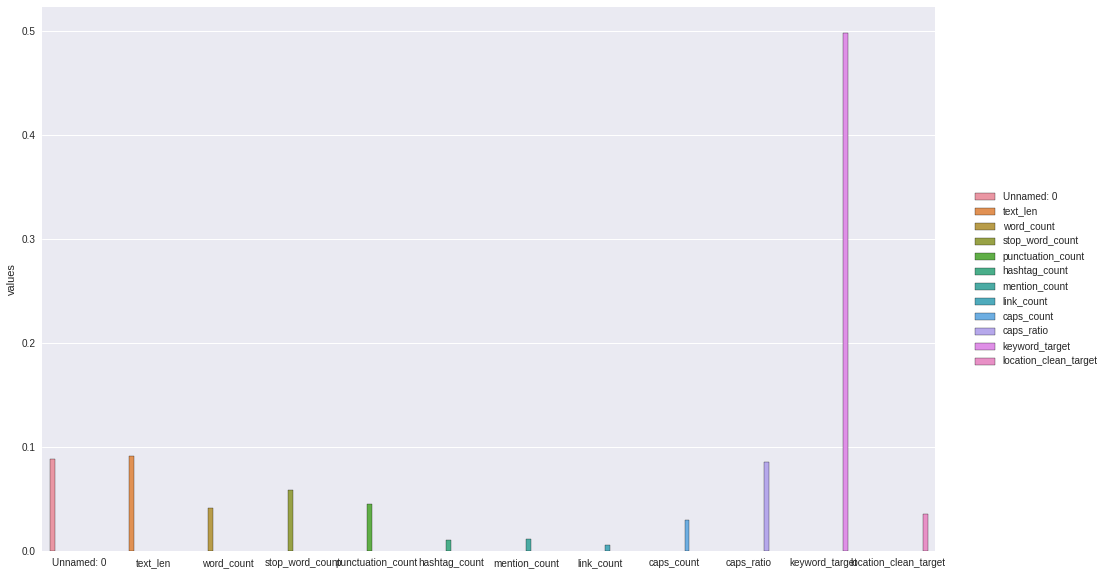

In [12]:

# plt styling parameters
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams["patch.force_edgecolor"] = True

df = pd.DataFrame({
    'names': columns,
    'values': importances
})

# create a color palette the length of the dataframe
colors = sns.color_palette('husl', n_colors=len(df))
# plot
p = sns.barplot(x=columns, y='values', data=df, hue='names')

# place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)